# 0. Imports

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tarfile
from tqdm.notebook import tqdm
import os

# 1. Dataset

In [2]:
dataset_path = 'dataset'

Training data

In [3]:
if os.path.exists(os.path.join(dataset_path, "train")):
    print("Dataset found! Skipping download.")
else:
    print("Dataset not found. Downloading and extracting it...")
    os.makedirs(dataset_path, exist_ok=True)
    !wget --show-progress https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar -O streethazards_train.tar
    with tarfile.open('streethazards_train.tar') as tar:
        tar.extractall(path='./dataset')
    os.remove('streethazards_train.tar')

Dataset not found. Downloading and extracting it...
--2025-04-25 09:55:54--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘streethazards_train.tar’

streethazards_train 100%[===================>]   8.74G  21.1MB/s    in 8m 4s   

2025-04-25 10:03:59 (18.5 MB/s) - ‘streethazards_train.tar’ saved [9386226176/9386226176]



Test data

In [4]:
if os.path.exists(os.path.join(dataset_path, "test")):
    print("Dataset found! Skipping download.")
else:
    print("Dataset not found. Downloading and extracting it...")
    os.makedirs(dataset_path, exist_ok=True)
    !wget --show-progress https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar -O streethazards_test.tar
    with tarfile.open('streethazards_test.tar') as tar:
        tar.extractall(path='./dataset')
    os.remove('streethazards_test.tar')

Dataset not found. Downloading and extracting it...
--2025-04-25 10:05:12--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘streethazards_test.tar’

streethazards_test. 100%[===================>]   2.00G  20.3MB/s    in 1m 44s  

2025-04-25 10:06:56 (19.8 MB/s) - ‘streethazards_test.tar’ saved [2150484992/2150484992]



In [5]:
def plot_sample_image(sample_image, sample_mask, sample_name=("","")):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(sample_image.permute(1,2,0))
    plt.title(f"Image {sample_name[0]}")
    plt.subplot(1,2,2)
    plt.imshow(sample_mask.permute(1,2,0))
    plt.title(f"Mask {sample_name[1]}")

    plt.show()

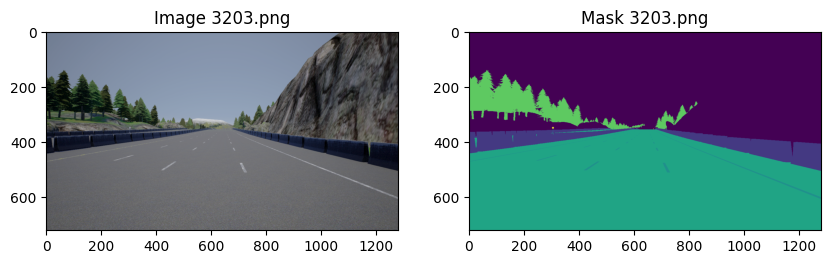

In [6]:
image_folder_train = os.path.join(dataset_path, "train/images/training/t1-3")
mask_folder_train = os.path.join(dataset_path, "train/annotations/training/t1-3")
len_dataset_train = len(os.listdir(image_folder_train))

idx = np.random.choice(len_dataset_train, size=None)

image_name, mask_name = (sorted(os.listdir(image_folder_train))[idx], sorted(os.listdir(mask_folder_train))[idx])

sample_image_train = read_image(os.path.join(image_folder_train,
                                sorted(os.listdir(image_folder_train))[idx]
                                ))
sample_mask_train = read_image(os.path.join(mask_folder_train,
                                sorted(os.listdir(mask_folder_train))[idx]
                                ))

plot_sample_image(sample_image_train,
                  sample_mask_train,
                  sample_name=(image_name, mask_name)
                  )

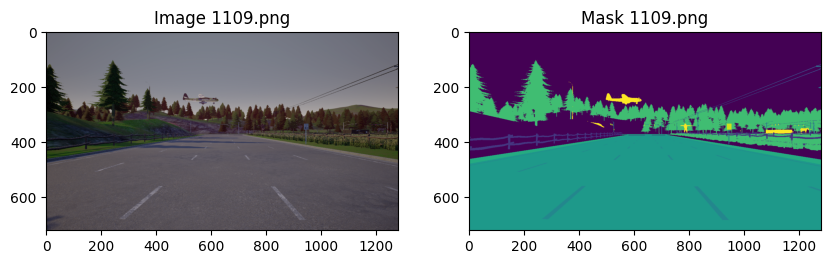

In [7]:
image_folder_test = os.path.join(dataset_path, "test/images/test/t6")
mask_folder_test = os.path.join(dataset_path, "test/annotations/test/t6")

len_dataset_test = len(os.listdir(image_folder_test))

idx = np.random.choice(len_dataset_test, size=None)

image_name, mask_name = (sorted(os.listdir(image_folder_test))[idx], sorted(os.listdir(mask_folder_test))[idx])

sample_image_test = read_image(os.path.join(image_folder_test,
                                image_name
                                ))
sample_mask_test = read_image(os.path.join(mask_folder_test,
                                mask_name
                                ))

plot_sample_image(sample_image_test,
                  sample_mask_test,
                  sample_name=(image_name, mask_name)
                  )

# Where do the labels start from? Is the anomaly class present in the training set?  
NB: i set the anomaly_label as 14 because i already know that labels start from 1, so for efficiency reasons i can do both the checks in only one iteration.

Starting the check for the training set...


  0%|          | 0/5125 [00:00<?, ?it/s]

Object classes starts from 1 (which represents the background). Need a fix!
The training dataset does NOT contain anomalies, as expected.
Check Done!

Starting the check for the test set...


  0%|          | 0/476 [00:00<?, ?it/s]

The test dataset DOES contain anomalies, as expected.


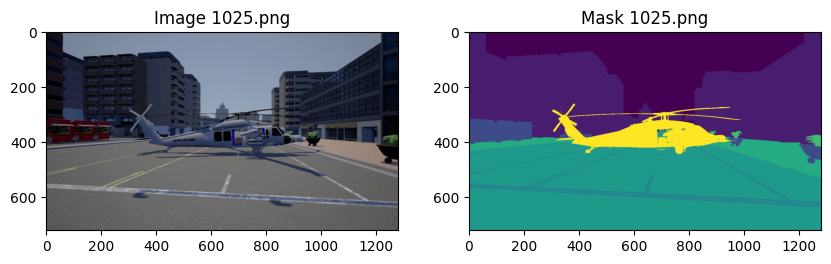

Object classes starts from 1 (which represents the background). Need a fix!
Check Done!


In [8]:
background_class = 0
anomaly_class = 14


zero_class_not_found_train, anomaly_class_not_found_train = True, True
zero_class_not_found_test, anomaly_class_found_test = True, False

print("Starting the check for the training set...")
for idx in tqdm(range(len_dataset_train)):
    image_name, mask_name = (sorted(os.listdir(image_folder_train))[idx], sorted(os.listdir(mask_folder_train))[idx])
    sample_image = read_image(os.path.join(image_folder_train,
                                image_name
                                ))
    sample_mask = read_image(os.path.join(mask_folder_train,
                                mask_name
                                ))

    obj_ids = torch.unique(sample_mask).tolist()

    if background_class in obj_ids:
        print(f"found a zero class: {idx}")
        print("Object classes starts from 0 (which represents the background). Everything is fine!")
        zero_class_not_found_train = False
        plot_sample_image(sample_image, sample_mask, sample_name=(image_name, mask_name))
        break
    elif anomaly_class in obj_ids:
        print(f"found an anomaly class: {idx}")
        print("This should not be present")
        anomaly_class_not_found_train = False
        plot_sample_image(sample_image, sample_mask, sample_name=(image_name, mask_name))

if zero_class_not_found_train:
    print("Object classes starts from 1 (which represents the background). Need a fix!")
if anomaly_class_not_found_train:
    print("The training dataset does NOT contain anomalies, as expected.")

print("Check Done!\n")

print("Starting the check for the test set...")
for idx in tqdm(range(len_dataset_test)):
    image_name, mask_name = (sorted(os.listdir(image_folder_test))[idx], sorted(os.listdir(mask_folder_test))[idx])
    sample_image = read_image(os.path.join(image_folder_test,
                                image_name
                                ))
    sample_mask = read_image(os.path.join(mask_folder_test,
                                mask_name
                                ))

    obj_ids = torch.unique(sample_mask).tolist()

    if background_class in obj_ids:
        print(f"found a zero class: {idx}")
        print("Object classes starts from 0 (which represents the background). Everything is fine!")
        zero_class_not_found_test = False
        plot_sample_image(sample_image, sample_mask, sample_name=(image_name, mask_name))
        break
    elif not anomaly_class_found_test and anomaly_class in obj_ids:
        print("The test dataset DOES contain anomalies, as expected.")
        anomaly_class_found_test = True
        plot_sample_image(sample_image, sample_mask, sample_name=(image_name, mask_name))

if zero_class_not_found_test:
    print("Object classes starts from 1 (which represents the background). Need a fix!")
if not anomaly_class_found_test:
    print("The test dataset does NOT contain anomalies. This is a problem!")
print("Check Done!")

## Most of the models works with the background/unlabeled class with value 0. When building the dataset class, i will simply subtract 1 from the mask tensor.

## most of the get_item has been taken from [this link](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In the code below, we are wrapping images, bounding boxes and masks into torchvision.tv_tensors.TVTensor classes so that we will be able to apply torchvision built-in transformations (new Transforms API) for the given object detection and segmentation task. Namely, image tensors will be wrapped by torchvision.tv_tensors.Image, bounding boxes into torchvision.tv_tensors.BoundingBoxes and masks into torchvision.tv_tensors.Mask. As torchvision.tv_tensors.TVTensor are torch.Tensor subclasses, wrapped objects are also tensors and inherit the plain torch.Tensor API.

# what you have modified:
- what you return from the getitem()
- the number of channels of the image.
- exclusion of background class
- check for the num_obj

In [29]:
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class StreetHazardsTrain(Dataset):
    label_mapping = {
            0: "unlabeled",
            1: "building",
            2: "fence",
            3: "other",
            4: "pedestrian",
            5: "pole",
            6: "road line" ,
            7: "road",
            8: "sidewalk",
            9: "vegetation",
            10: "car",
            11: "wall",
            12: "traffic sign",
            13: "anomaly"
        }

    def __init__(self, split, transforms=None):
        super().__init__()
        self.split = split

        if self.split in ["train", "training"]:
            self.img_root = os.path.join(dataset_path, "train/images/training/t1-3")
            self.mask_root = os.path.join(dataset_path, "train/annotations/training/t1-3")
        else:
            self.img_root = os.path.join(dataset_path, "train/images/validation/t4")
            self.mask_root = os.path.join(dataset_path, "train/annotations/validation/t4")

        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.img_root))
        self.masks = sorted(os.listdir(self.mask_root))


    def __getitem__(self, idx):
        img = read_image(os.path.join(self.img_root, self.imgs[idx]))
        img = img[:3, ...]
        mask = read_image(os.path.join(self.mask_root, self.masks[idx]))
        mask -= 1 # i subtract 1 to correct the labels

        # Wrap sample and mask into torchvision tv_tensors:
        # fundamentals to let the transform module to apply
        # the transformations together
        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(mask)

        # I immediately apply the transformation, so
        # i have no problems with transforming the tensors.
        if self.transforms is not None:
            mask, img = self.transforms(mask, img)

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        if num_objs == 0:
            # Set to empty tensors to avoid errors in loss calculation
            boxes = torch.empty((0, 4), dtype=torch.float32)
            labels = torch.empty((0,), dtype=torch.int64)
            masks = torch.empty((0, mask.shape[1], mask.shape[2]), dtype=torch.uint8)
        else:

            # split the color-encoded mask into a set
            # of binary masks
            masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

            # get bounding box coordinates for each mask
            boxes = masks_to_boxes(masks)

            # there is only one class
            # labels = torch.ones((num_objs,), dtype=torch.int64)
            labels = torch.tensor([obj_id.item() for obj_id in obj_ids], dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        # i guess this is not useful in our scenario, but most of the
        # coco benchmarks use it, so let's keep it for compatibility
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["mask_image"] = mask # for plotting purposes
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["boxes"].data = target["boxes"].data.round()
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # if self.transforms is not None:
        #     img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.imgs)

    def get_name(self, idx):
        return (self.imgs[idx], self.masks[idx])

    @classmethod
    def get_label(cls, idx):
        return cls.label_mapping.get(idx, "unknown label")

In [22]:
train_dataset = StreetHazardsTrain(split="train")
validation_dataset = StreetHazardsTrain(split="validation")

# test

In [143]:
train_dataset = StreetHazardsTrain(split="train", transforms=get_transform(train=True, shape=250))
validation_dataset = StreetHazardsTrain(split="validation")

In [142]:
from torchvision.transforms import v2 as T


def get_transform(train, shape=512):
    transforms = []
    transforms.append(T.Resize(shape, antialias=True))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [128]:
type(sample_image_train)

torch.Tensor

In [129]:
dataset = StreetHazardsTrain(split='train', transforms=get_transform(train=True))
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [130]:
images[1].shape

torch.Size([3, 512, 910])

In [131]:
targets[1]['mask_image'].shape

torch.Size([1, 512, 910])

In [132]:
targets[1]['boxes']

BoundingBoxes([[  0.,   0., 909., 307.],
               [  0., 179., 909., 262.],
               [652., 242., 753., 270.],
               [ 43.,   0., 792., 301.],
               [  0., 303., 909., 511.],
               [  0., 263., 909., 511.],
               [  0., 262., 909., 327.],
               [  0.,   0., 909., 285.],
               [705., 253., 755., 282.],
               [  0., 235., 909., 306.],
               [138.,  45., 636., 147.]], format=BoundingBoxFormat.XYXY, canvas_size=[512, 910])

In [133]:
imgs, trgts = next(iter(train_dataset))

In [134]:
trgts['boxes']

BoundingBoxes([[   0.,    0., 1279.,  413.],
               [   0.,  197., 1279.,  413.],
               [ 970.,  379., 1279.,  481.],
               [ 171.,   91., 1030.,  423.],
               [   0.,  389., 1279.,  719.],
               [   0.,  386., 1279.,  719.],
               [   0.,  385., 1279.,  552.],
               [ 969.,   15., 1279.,  474.],
               [   0.,  397.,   98.,  413.],
               [ 307.,  176.,  938.,  389.]], format=BoundingBoxFormat.XYXY, canvas_size=[720, 1280])

In [38]:
targets[0]['boxes']

tensor([[7.1094e-01, 0.0000e+00, 9.1000e+02, 2.8942e+02],
        [7.1094e-01, 8.2489e+01, 9.1000e+02, 3.0720e+02],
        [7.1094e-01, 0.0000e+00, 5.5240e+02, 2.9013e+02],
        [7.1094e-01, 2.8729e+02, 9.1000e+02, 5.1129e+02],
        [7.1094e-01, 2.7947e+02, 9.1000e+02, 5.1129e+02],
        [7.1094e-01, 2.6738e+02, 9.1000e+02, 4.3449e+02],
        [2.4954e+02, 2.5031e+02, 5.5951e+02, 3.0364e+02],
        [1.3508e+02, 6.1156e+01, 5.5169e+02, 2.7804e+02]])

# end of the test

Ground truth objects in the image:
['building', 'fence', 'other', 'pole', 'road line', 'road', 'sidewalk', 'vegetation', 'car', 'traffic sign']


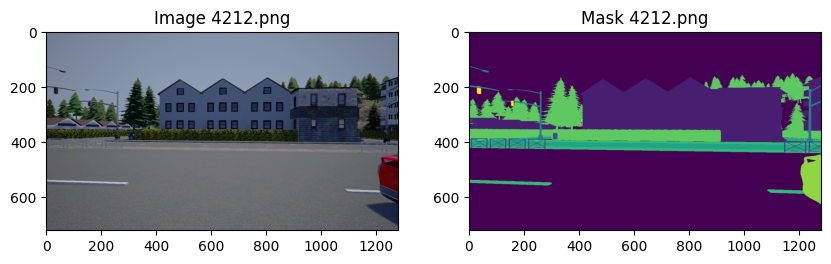

In [23]:
faulty_image = "4212.png"
idx = train_dataset.imgs.index(faulty_image)

# idx = np.random.choice(len_dataset_train, size=None)
# idx = 0

sample_image, target = train_dataset[idx]
sample_mask = target['mask_image']
labels = [StreetHazardsTrain.get_label(label) for label in target['labels'].tolist()]

print("Ground truth objects in the image:")
print(labels)

plot_sample_image(sample_image, sample_mask, sample_name=train_dataset.get_name(idx))

# This is taken by the last block of 6. Object detection finetuning and adapted.

Which object do you want to segment in the image? choose it from this list:
['unlabeled', 'building', 'fence', 'other', 'pole', 'road line', 'road', 'sidewalk', 'vegetation', 'car', 'traffic sign']
I choose: car
You will see it segmented in black in the image


[]

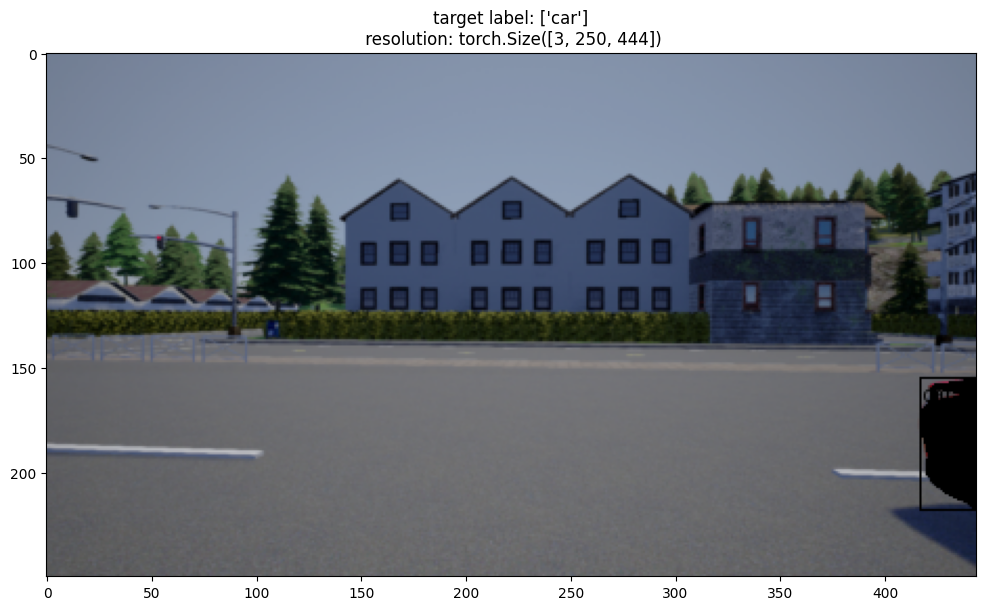

In [145]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

what_to_segment = input(f"Which object do you want to segment in the image? choose it from this list:\n{labels}\nI choose: ")
while(what_to_segment not in labels):
    what_to_segment = input(f"{what_to_segment} is not there! Try again: ")
print("You will see it segmented in black in the image")
idx_1 = labels.index(what_to_segment)
idx_2 = idx_1 + 1
# alpha = 0.5
alpha = 1

image = sample_image[:3, ...]
labels = [StreetHazardsTrain.get_label(label) for label in target['labels'].tolist()]
pred_boxes = target["boxes"].long()
masks = (target["masks"] > 0.7).squeeze(1)

output_image = draw_bounding_boxes(image, pred_boxes[idx_1:idx_2,...], labels[idx_1:idx_2])
output_image = draw_segmentation_masks(output_image, masks[idx_1:idx_2, ...], alpha=alpha)

plt.figure(figsize=(12, 12))
title = f"target label: {labels[idx_1:idx_2]}\n resolution: {output_image.shape}"
plt.title(title)
plt.imshow(output_image.permute(1, 2, 0))
plt.plot()

as we can see, the image above is faulty since the road has actually been labeled as 'unlabeled' (i.e. background)

In [24]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [12]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [18]:
from torchvision.transforms import v2 as T


def get_transform(train, shape=512):
    transforms = []
    transforms.append(T.Resize(shape, antialias=True))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    # Convert image to 3 channels by selecting the first 3 channels (RGB)
    # transforms.append(T.Lambda(lambda img: img[:3, ...])) # This line is added
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [30]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = StreetHazardsTrain(split='train', transforms=get_transform(train=True))
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 179MB/s]


{'loss_classifier': tensor(1.4649, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4087, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.6381, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.3938, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


it works! let's try to train it with the code of the [tutorial you are referring to](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [31]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 13 # we don't consider the anomaly class.
# use our dataset and defined transformations
dataset = StreetHazardsTrain('train', get_transform(train=True, shape=250))
dataset_test = StreetHazardsTrain('validation', get_transform(train=False, shape=250))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [99]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"Using {device}.")

Using cpu.
